# Johnson-lindenstrauss for representation learning

- See `train.ipynb` for siamese network results

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data

- See data.ipynb for data preparation

In [3]:
tensors_1kg = torch.load("1kg-g2g-tensors.pt")
targets_1kg = pd.read_csv("1kg-g2g_l2.tsv",sep="\t")
tensors_pcawg = torch.load("pcawg-g2g-tensors.pt")
targets_pcawg = pd.read_csv("pcawg-g2g_l2.tsv",sep="\t")
df_1kg = pd.read_csv("1kg-g2g_vecs.tsv",sep="\t", index_col=0)
df_pcawg = pd.read_csv("pcawg-g2g_vecs.tsv",sep="\t", index_col=0)
print(list(tensors_1kg.items())[0])
print(list(tensors_pcawg.items())[0])
print(targets_1kg.shape)
print(targets_pcawg.shape)
print(df_1kg.shape)
print(df_pcawg.shape)

('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))
('FI26317', tensor([1., 6., 6.,  ..., 8., 2., 1.]))
(3211845, 3)
(10011, 3)
(2535, 18721)
(142, 18721)


In [4]:
df_1kg.head()

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1


In [5]:
df_pcawg.head()

,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
FI26317,1,6,6,2,7,5,3,7,7,16,...,9,2,4,3,1,18,7,8,2,1
FI22889,10,12,5,12,2,7,3,5,3,16,...,5,2,9,3,8,5,1,9,2,1
FI45246,12,11,8,1,2,6,4,10,8,8,...,6,12,6,1,4,7,7,19,8,1
FI19114,7,9,10,10,6,4,6,33,17,14,...,11,11,6,7,5,10,10,7,9,5
FI45994,3,5,1,4,1,1,1,1,3,4,...,2,1,1,1,1,7,1,1,1,1


In [6]:
# stack rows of 1kg and pcawg
df_global = pd.concat([df_1kg, df_pcawg])
print(df_global.shape)

(2677, 18721)


In [7]:
samples_1kg = df_1kg.index
sample_pairs_1kg = list(itertools.combinations(samples_1kg, 2))
print(len(sample_pairs_1kg))
sample_pairs_1kg[:5]

3211845


[('NA18614', 'HG01918'),
 ('NA18614', 'NA18546'),
 ('NA18614', 'HG02855'),
 ('NA18614', 'HG03565'),
 ('NA18614', 'NA19324')]

In [8]:
samples_pcawg = df_pcawg.index
sample_pairs_pcawg = list(itertools.combinations(samples_pcawg, 2))
print(len(sample_pairs_pcawg))
sample_pairs_pcawg[:5]

10011


[('FI26317', 'FI22889'),
 ('FI26317', 'FI45246'),
 ('FI26317', 'FI19114'),
 ('FI26317', 'FI45994'),
 ('FI26317', 'FI34411')]

In [9]:
sample_pairs_across = list(itertools.product(samples_1kg, samples_pcawg))
print(len(sample_pairs_across))
sample_pairs_across[:5]


359970


[('NA18614', 'FI26317'),
 ('NA18614', 'FI22889'),
 ('NA18614', 'FI45246'),
 ('NA18614', 'FI19114'),
 ('NA18614', 'FI45994')]

In [10]:
sample_pairs_global = sample_pairs_1kg + sample_pairs_pcawg + sample_pairs_across
print(len(sample_pairs_global))
sample_pairs_global[:5]

3581826


[('NA18614', 'HG01918'),
 ('NA18614', 'NA18546'),
 ('NA18614', 'HG02855'),
 ('NA18614', 'HG03565'),
 ('NA18614', 'NA19324')]

- Need to compute across population distances

Migrate this code to `data.ipynb` later

In [38]:
def dist_sq_l2(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    return sample_pair, np.linalg.norm(s1 - s2) ** 2

# dist_sq_l2(sample_pairs_across[0], df_global)

In [13]:
l2s = []
for sp in sample_pairs_across:
    l2s.append(dist_sq_l2(sp, df_global))


In [14]:
df_l2s_across = pd.DataFrame(l2s, columns=["sample_pair", "l2"])
df_l2s_across[["s_i", "s_j"]] = pd.DataFrame(
    df_l2s_across["sample_pair"].tolist(), index=df_l2s_across.index
)
df_l2s_across.drop("sample_pair", axis=1, inplace=True)
df_l2s_across.to_csv(
    "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/across-g2g_l2.tsv", sep="\t", index=False
)

In [12]:
targets_across = pd.read_csv("/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/across-g2g_l2.tsv", sep="\t")
targets_across.head()

,l2,s_i,s_j
0,4881756.0,NA18614,FI26317
1,4110175.0,NA18614,FI22889
2,48382528.0,NA18614,FI45246
3,13697953.0,NA18614,FI19114
4,282248.0,NA18614,FI45994


In [13]:
targets_global = pd.concat([targets_1kg, targets_pcawg, targets_across])
print(targets_global.shape)

(3581826, 3)


In [57]:
targets_global.to_csv(
    "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/global-g2g_l2.tsv", sep="\t", index=False
)

### Margin parameter selection

- **Ignore this, it no longer makes sense** 
- Move this to train/data later

In [26]:
med_sq_l2_across = targets_across['l2'].median()
med_sq_l2_1kg = targets_1kg['l2'].median()
med_sq_l2_pcawg = targets_pcawg['l2'].median()
print(
    f"median sq l2 across: {med_sq_l2_across}, 1kg: {med_sq_l2_1kg}, pcawg: {med_sq_l2_pcawg}"
)

median sq l2 across: 6451095.999999999, 1kg: 1759.0000000000002, pcawg: 2469098.0


In [31]:
# bar plot log medians
fig = px.bar(
    x=["across", "1kg", "pcawg"],
    y=np.log([med_sq_l2_across, med_sq_l2_1kg, med_sq_l2_pcawg]),
    title="log median squared L2 distance",
)
fig.show()

## Baseline: johnson-lindenstrauss

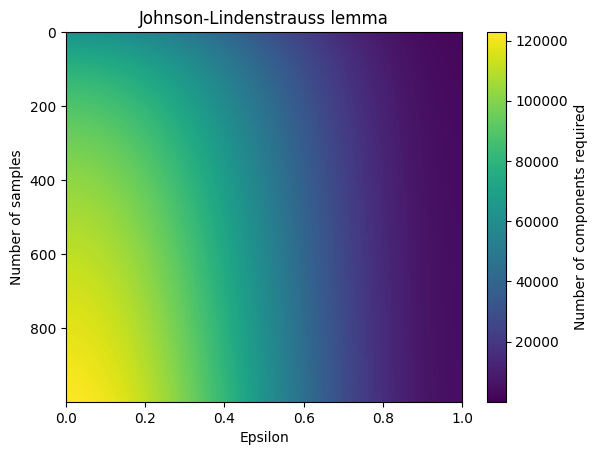

In [122]:
# visualize the effect of dataset size and distortion error threshold
# on the number of components required for Johnson-Lindenstrauss lemma
def jl_lemma(n, epsilon):
    k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
    return k
n = np.linspace(10, 100, 1000, 10000)
epsilons = [0.01, 0.05, 0.1, 0.5]
cart = itertools.product(n, epsilons)
# heatmap
k_values = [jl_lemma(n, epsilon) for n, epsilon in cart]
k_values = np.array(k_values).reshape(1000, 4)
plt.imshow(k_values, aspect="auto")
colorbar = plt.colorbar()
colorbar.set_label("Number of components required")
plt.xlabel("Epsilon")
plt.ylabel("Number of samples")
plt.title("Johnson-Lindenstrauss lemma")
plt.xlim(left=0, right=1)
plt.show()
    

### Within population

In [2]:
np.random.seed(0)

#### 1kg

##### Epsilon = 0.1


In [ ]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = df_1kg.shape[0]
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

2086

In [38]:
jl_1kg = GaussianRandomProjection(n_components=k, random_state=0)
df_1kg_jl = pd.DataFrame(jl_1kg.fit_transform(df_1kg))
print(df_1kg_jl.shape)
df_1kg_jl.index = df_1kg.index
df_1kg_jl.head()

(2535, 2086)


,0,1,2,3,4,5,6,7,8,9,...,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085
NA18614,-2.051126,-1.456229,1.092002,-2.992604,5.724252,6.829133,3.691685,6.263694,6.066922,-0.738450,...,0.272980,0.782090,3.451776,2.813435,1.412871,4.385370,3.945090,-1.796855,-3.564690,-0.671526
HG01918,-4.188421,-2.929395,1.031436,-3.002698,6.823088,4.705258,4.560896,7.202094,4.654009,-2.028744,...,0.236549,2.388977,1.831683,3.435842,1.664522,3.971462,2.639332,-2.005333,-2.661582,-0.368578
NA18546,-1.617051,-2.816215,-0.656346,-1.867814,6.993427,5.637329,4.379765,7.822922,4.497582,-0.964018,...,0.792185,3.809103,3.518849,3.948816,0.977811,5.082008,2.365027,-2.099849,-2.363069,-2.201466
HG02855,-3.507558,-2.334668,1.478754,-2.366508,5.864569,5.478177,4.399189,5.801723,3.456933,-0.583059,...,1.128956,1.588741,1.296292,2.986274,1.078364,4.191972,3.878989,-1.570710,-2.510935,-0.947581
HG03565,-2.866200,-2.596682,1.888015,-2.184448,6.031157,5.951043,4.294785,5.342199,4.487081,-1.275908,...,1.151451,1.673860,2.108185,3.293141,1.698277,3.719313,3.614750,-1.794606,-2.213681,-0.841359


In [39]:
# highlight 2 samples
samples2 = df_1kg.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

HG03780 HG04054


In [ ]:
# # plot original and jl tsne

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# axes[0].scatter(df_tsne_original.iloc[:, 0], df_tsne_original.iloc[:, 1], alpha=0.5)
# axes[0].set_title("Original TSNE")
# axes[0].scatter(
#     df_tsne_original.loc[i1, 0],
#     df_tsne_original.loc[i1, 1],
#     color="red",
#     s=50,
#     label=i1,
# )
# axes[0].scatter(
#     df_tsne_original.loc[i2, 0],
#     df_tsne_original.loc[i2, 1],
#     color="purple",
#     s=50,
#     label=i2,
# )
# axes[0].legend()
# # axes[0].annotate('Point 1', (df_tsne_original.loc[i1, 0], df_tsne_original.loc[i1, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# # axes[0].annotate('Point 2', (df_tsne_original.loc[i2, 0], df_tsne_original.loc[i2, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

# axes[1].scatter(df_tsne_jl.iloc[:, 0], df_tsne_jl.iloc[:, 1], alpha=0.5)
# axes[1].set_title("Johnson-Lindenstrauss TSNE")
# axes[1].scatter(
#     df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1], color="red", s=50, label=i1
# )
# axes[1].scatter(
#     df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1], color="purple", s=50, label=i2
# )
# axes[1].legend()
# # axes[1].annotate('Point 1', (df_tsne_jl.loc[i1, 0], df_tsne_jl.loc[i1, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='red')
# # axes[1].annotate('Point 2', (df_tsne_jl.loc[i2, 0], df_tsne_jl.loc[i2, 1]),
# #                  textcoords="offset points", xytext=(0,10), ha='center', color='purple')

def tsne_contrastive(df1, df2,figtitle=None,  title1='tsne1', title2='tsne2', samples=None):
    # df 1
    tsne1 = TSNE(n_components=2, random_state=0)
    df_tsne1 = pd.DataFrame(tsne1.fit_transform(df1))
    df_tsne1.index = df1.index

    tsne2 = TSNE(n_components=2, random_state=0)
    df_tsne2 = pd.DataFrame(tsne2.fit_transform(df2))
    df_tsne2.index = df2.index

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].scatter(df_tsne1.iloc[:, 0], df_tsne1.iloc[:, 1], alpha=0.5)
    axes[0].set_title(title1)
    if samples:
        for i in samples:
            axes[0].scatter(
                df_tsne1.loc[i, 0], df_tsne1.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df1.loc[samples[0]] - df1.loc[samples[1]]) ** 2
        axes[0].set_title(f"{title1}\nSamples' squared L2 distance: {d:.2f}")
    axes[0].legend()

    # df 2
    axes[1].scatter(df_tsne2.iloc[:, 0], df_tsne2.iloc[:, 1], alpha=0.5)
    axes[1].set_title(title2)
    if samples:
        for i in samples:
            axes[1].scatter(
                df_tsne2.loc[i, 0], df_tsne2.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df2.loc[samples[0]] - df2.loc[samples[1]]) ** 2
        axes[1].set_title(f"{title2}\nSamples' squared L2 distance: {d:.2f}")
    axes[1].legend()
    if figtitle:
        fig.suptitle(figtitle)
# note: rmse is computed below
tsne_contrastive(df_1kg, df_1kg_jl, figtitle=f'MSE={mse_jl_eps_01:.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

MSE

In [49]:
def dist_sq_l2(sample_pair, df_vec):
    s1 = df_vec.loc[sample_pair[0], :]
    s2 = df_vec.loc[sample_pair[1], :]
    return sample_pair, np.linalg.norm(s1 - s2) ** 2

In [ ]:
# runtime: 6min 30s on 15 cores
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_1kg:
    l2s_jl.append(dist_sq_l2(sp, df_1kg_jl))

In [56]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/1kg-g2g_l2-jl_eps_01.tsv"
l2_jl_1kg_eps_01 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_1kg_eps_01[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_1kg_eps_01["sample_pair"].tolist(), index=l2_jl_1kg_eps_01.index
)
l2_jl_1kg_eps_01.drop("sample_pair", axis=1, inplace=True)
l2_jl_1kg_eps_01.to_csv(
    path, sep="\t", index=False
)

In [57]:
l2_jl_1kg_eps_01.head()

,l2,s_i,s_j
0,2085.554820,NA18614,HG01918
1,3077.700080,NA18614,NA18546
2,1392.259277,NA18614,HG02855
3,1440.585380,NA18614,HG03565
4,1212.932743,NA18614,NA19324


In [ ]:
y_true = targets_1kg["l2"].values
y_pred = l2_jl_1kg_eps_01["l2"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_01 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_01:.2f}")

Mean Squared Error: 142340.55


##### Epsilon = 0.05

In [64]:
# distortion threshold
epsilon = 0.05
# compute dimensionality
# such that the distortion is less than epsilon
n = df_1kg.shape[0]
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

8360

In [65]:
jl_1kg = GaussianRandomProjection(n_components=k, random_state=0)
df_1kg_jl = pd.DataFrame(jl_1kg.fit_transform(df_1kg))
print(df_1kg_jl.shape)
df_1kg_jl.index = df_1kg.index
df_1kg_jl.head()

(2535, 8360)


,0,1,2,3,4,5,6,7,8,9,...,8350,8351,8352,8353,8354,8355,8356,8357,8358,8359
NA18614,-1.024581,-0.727417,0.545478,-1.494870,2.859386,3.411297,1.844076,3.128849,3.030557,-0.368872,...,-0.002120,-1.463751,0.376657,0.315204,0.709395,1.273886,-0.673868,1.783466,-0.570722,-2.561936
HG01918,-2.092206,-1.463295,0.515224,-1.499912,3.408278,2.350377,2.278265,3.597599,2.324777,-1.013401,...,0.433145,-1.407515,0.429748,1.105998,0.498163,1.056337,0.176174,2.272941,-0.606942,-2.836404
NA18546,-0.807751,-1.406759,-0.327859,-0.933013,3.493366,2.815966,2.187786,3.907716,2.246638,-0.481548,...,0.105231,-0.642746,-0.112634,1.139925,0.915783,1.582422,-1.369532,1.445727,-0.265679,-2.507616
HG02855,-1.752100,-1.166217,0.738669,-1.182121,2.929477,2.736466,2.197488,2.898084,1.726812,-0.291250,...,0.337736,-1.258151,0.061470,0.252331,1.066095,1.282934,-0.180930,1.904171,-0.759657,-2.677754
HG03565,-1.431728,-1.297098,0.943104,-1.091179,3.012691,2.972673,2.145336,2.668542,2.241393,-0.637343,...,0.503241,-1.021546,-0.124253,0.802698,0.523458,1.018224,-0.072286,2.042622,-0.244583,-2.882225


In [66]:
# runtime: 6min 30s on 15 cores
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_1kg:
    l2s_jl.append(dist_sq_l2(sp, df_1kg_jl))

In [67]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/1kg-g2g_l2-jl_eps_05.tsv"
l2_jl_1kg_eps_05 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_1kg_eps_05[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_1kg_eps_05["sample_pair"].tolist(), index=l2_jl_1kg_eps_05.index
)
l2_jl_1kg_eps_05.drop("sample_pair", axis=1, inplace=True)
l2_jl_1kg_eps_05.to_csv(
    path, sep="\t", index=False
)

In [68]:
l2_jl_1kg_eps_05.head()

,l2,s_i,s_j
0,2106.982584,NA18614,HG01918
1,2958.252785,NA18614,NA18546
2,1373.584920,NA18614,HG02855
3,1446.860729,NA18614,HG03565
4,1230.224699,NA18614,NA19324


In [69]:
y_true = targets_1kg["l2"].values
y_pred = l2_jl_1kg_eps_05["l2"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_05 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_05:.2f}")

Mean Squared Error: 66081.82


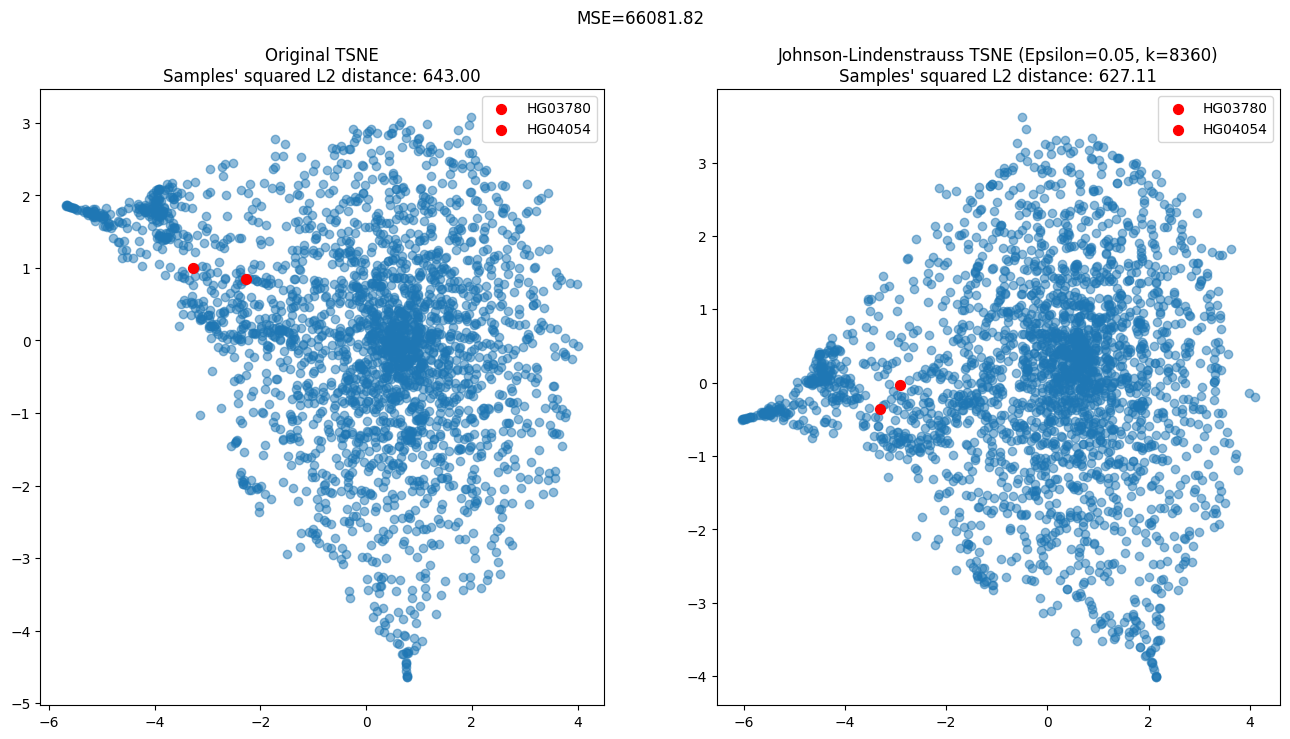

In [70]:
tsne_contrastive(df_1kg, df_1kg_jl, figtitle=f'MSE={mse_jl_eps_05:.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

#### PCAWG

##### Epsilon = 0.1

In [71]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = df_pcawg.shape[0]
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

1321

In [72]:
# highlight 2 samples
samples2 = df_pcawg.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

FI35723 FI9742


In [73]:
jl_pcawg = GaussianRandomProjection(n_components=k, random_state=0)
df_pcawg_jl = pd.DataFrame(jl_pcawg.fit_transform(df_pcawg))
print(df_pcawg_jl.shape)
df_pcawg_jl.index = df_pcawg.index
df_pcawg_jl.head()

(142, 1321)


,0,1,2,3,4,5,6,7,8,9,...,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
FI26317,-49.666852,-108.336882,6.128143,18.763814,69.530440,-7.843476,18.176223,5.118615,79.598320,-48.489163,...,34.095078,-7.268143,-36.529549,-22.187465,-135.386272,23.462225,-46.100230,-23.173991,-84.425788,69.182600
FI22889,-66.558064,-101.189798,-10.769629,-13.411151,111.418035,87.297143,-20.341123,30.476550,87.997372,-48.412030,...,-5.269248,-63.674870,-13.287579,-19.766368,-58.928788,20.559434,3.641229,12.240668,-71.200215,57.866189
FI45246,-174.164764,-267.311185,-3.692647,189.960701,69.330041,-293.861080,12.140864,-254.656488,266.305512,-0.191582,...,68.103258,100.420153,-145.017230,-142.797225,-440.711356,88.069165,-364.787573,-146.664014,-321.408362,268.455395
FI19114,-84.852257,-136.167507,-52.909014,7.496344,122.763968,23.502183,-17.054898,10.785753,172.474385,-29.476725,...,35.506475,3.614527,-94.046133,-49.728735,-192.764022,16.795368,-78.350934,-30.983265,-191.717500,88.836919
FI45994,-9.800908,-13.933289,1.712032,-1.300154,30.381405,20.933952,9.328660,-0.331684,20.981956,-16.600458,...,-14.943375,-16.809154,-6.677518,14.217403,-23.278201,12.038635,-0.065529,0.783322,-35.890574,13.785545


In [75]:
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_pcawg:
    l2s_jl.append(dist_sq_l2(sp, df_pcawg_jl))

In [76]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/pcawg-g2g_l2-jl_eps_01.tsv"
l2_jl_pcawg_eps_01 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_pcawg_eps_01[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_pcawg_eps_01["sample_pair"].tolist(), index=l2_jl_pcawg_eps_01.index
)
l2_jl_pcawg_eps_01.drop("sample_pair", axis=1, inplace=True)
l2_jl_pcawg_eps_01.to_csv(
    path, sep="\t", index=False
)

In [78]:
l2_jl_pcawg_eps_01.head()

,l2,s_i,s_j
0,1.616143e+06,FI26317,FI22889
1,2.559835e+07,FI26317,FI45246
2,3.290963e+06,FI26317,FI19114
3,3.211166e+06,FI26317,FI45994
4,2.446058e+06,FI26317,FI34411


In [96]:
y_true = targets_pcawg["l2"].values
y_pred = l2_jl_pcawg_eps_01["l2"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_01 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_01:.2f}")
print(np.log10(mse_jl_eps_01))

Mean Squared Error: 932211698040.02
11.969514548459637


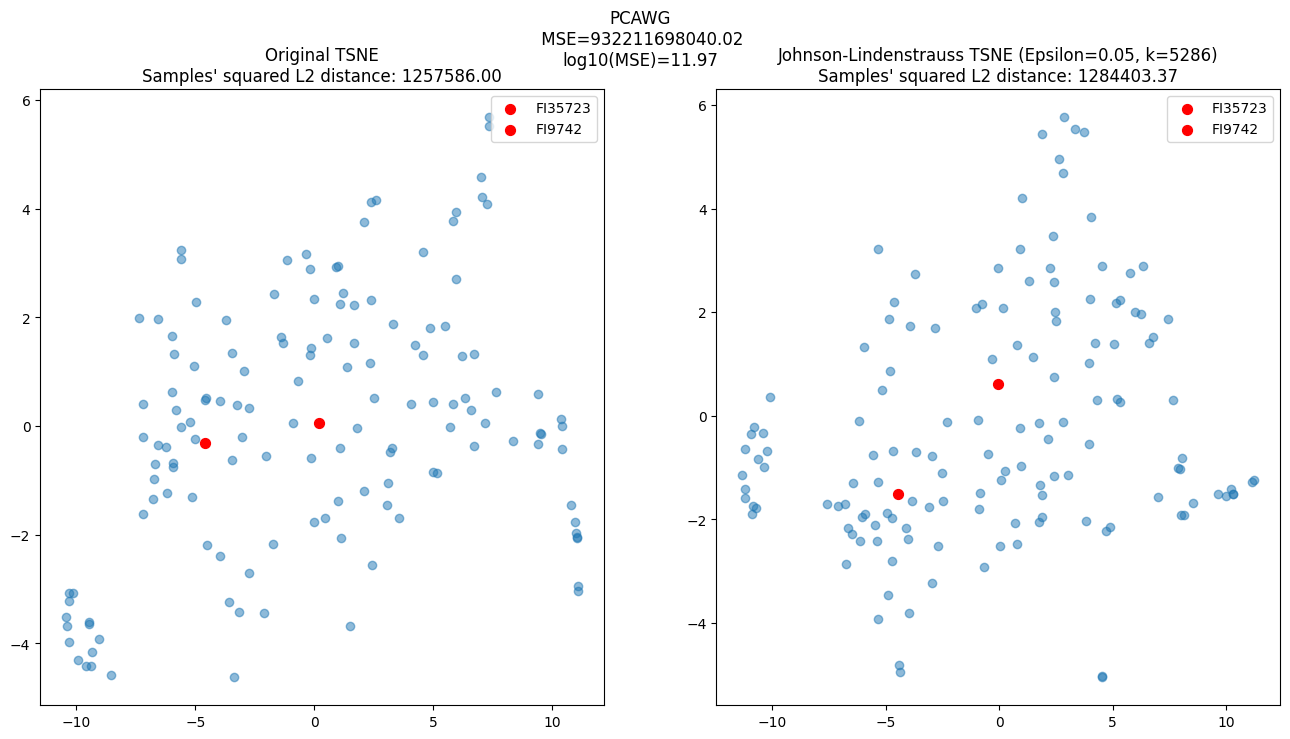

In [98]:
tsne_contrastive(df_pcawg, df_pcawg_jl, figtitle=f'PCAWG\n MSE={mse_jl_eps_01:.2f}\nlog10(MSE)={np.log10(mse_jl_eps_01):.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

##### Epsilon = 0.05

In [87]:
# distortion threshold
epsilon = 0.05
# compute dimensionality
# such that the distortion is less than epsilon
n = df_pcawg.shape[0]
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

5286

In [88]:
# highlight 2 samples
samples2 = df_pcawg.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

FI35723 FI9742


In [89]:
jl_pcawg = GaussianRandomProjection(n_components=k, random_state=0)
df_pcawg_jl = pd.DataFrame(jl_pcawg.fit_transform(df_pcawg))
print(df_pcawg_jl.shape)
df_pcawg_jl.index = df_pcawg.index
df_pcawg_jl.head()

(142, 5286)


,0,1,2,3,4,5,6,7,8,9,...,5276,5277,5278,5279,5280,5281,5282,5283,5284,5285
FI26317,-24.828728,-54.158193,3.063492,9.380132,34.758642,-3.920996,9.086392,2.558823,39.791630,-24.239995,...,10.436787,-22.269105,-10.577246,-6.110316,4.198047,52.840916,-2.279858,39.433102,-12.509578,-0.643762
FI22889,-33.272736,-50.585326,-5.383796,-6.704307,55.698477,43.640313,-10.168637,15.235392,43.990362,-24.201435,...,1.612649,-25.112304,7.479672,-4.917962,13.528926,44.205673,-15.342283,20.442666,-18.316296,-1.109606
FI45246,-87.065906,-133.630306,-1.845974,94.962381,34.658462,-146.902741,6.069283,-127.304154,133.127564,-0.095773,...,-13.149197,-10.274564,-61.258354,-41.975903,33.573597,86.440126,33.624819,99.482551,-137.276942,-83.930202
FI19114,-42.418102,-68.070872,-26.449502,3.747463,61.370371,11.748868,-8.525836,5.391856,86.220877,-14.735574,...,8.382636,-37.013510,-5.989270,-22.041050,16.155080,76.432828,-27.244173,70.617667,-50.469299,14.594743
FI45994,-4.899527,-6.965326,0.855854,-0.649954,15.187829,10.464996,4.663448,-0.165811,10.488993,-8.298659,...,-1.131740,-10.921024,-1.152110,-5.228685,1.362595,16.078855,-9.121115,6.194666,-3.217047,-2.224423


In [90]:
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_pcawg:
    l2s_jl.append(dist_sq_l2(sp, df_pcawg_jl))

In [91]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/pcawg-g2g_l2-jl_eps_05.tsv"
l2_jl_pcawg_eps_05 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_pcawg_eps_05[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_pcawg_eps_05["sample_pair"].tolist(), index=l2_jl_pcawg_eps_05.index
)
l2_jl_pcawg_eps_05.drop("sample_pair", axis=1, inplace=True)
l2_jl_pcawg_eps_05.to_csv(
    path, sep="\t", index=False
)

In [86]:
l2_jl_pcawg_eps_05.head()

,l2,s_i,s_j
0,1.623096e+06,FI26317,FI22889
1,2.603808e+07,FI26317,FI45246
2,3.408316e+06,FI26317,FI19114
3,3.376673e+06,FI26317,FI45994
4,2.447473e+06,FI26317,FI34411


In [102]:
y_true = targets_pcawg["l2"].values
y_pred = l2_jl_pcawg_eps_05["l2"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_05 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_05:.2f}")
print(round(np.log10(mse_jl_eps_05), 2))

Mean Squared Error: 316072690587.83
11.5


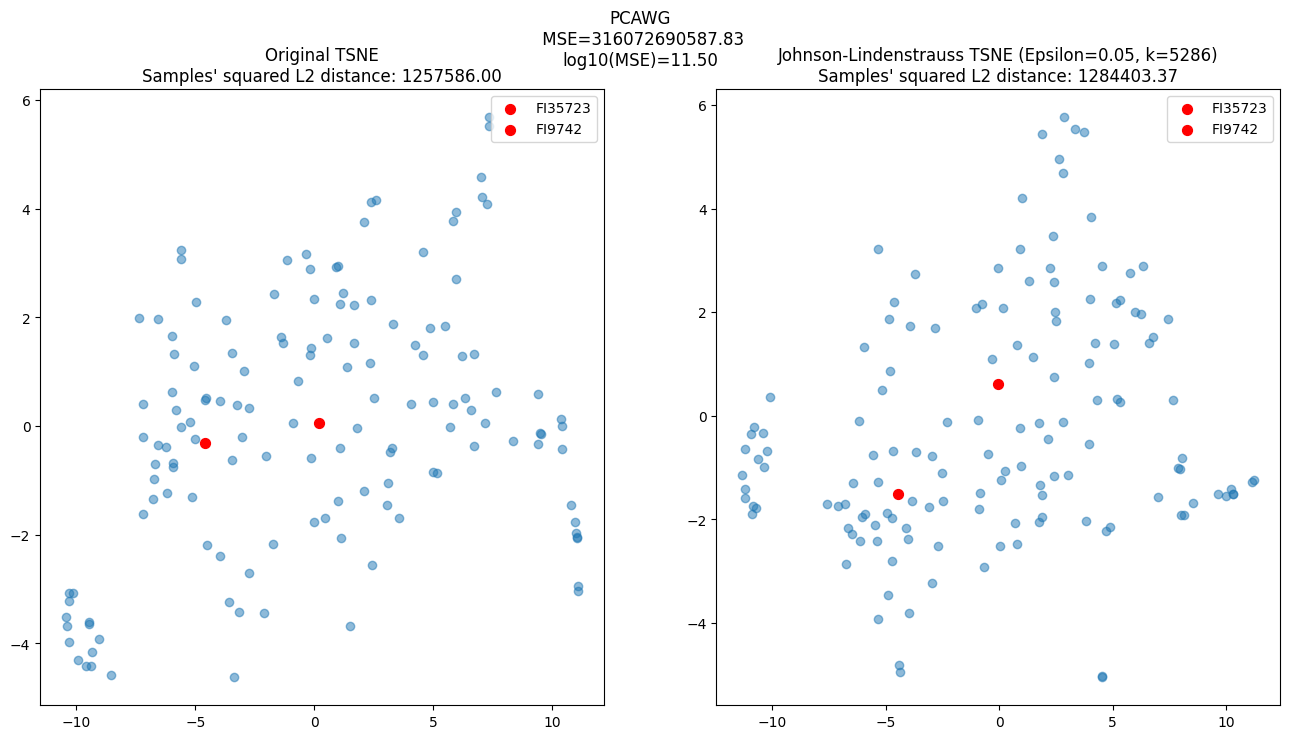

In [103]:
tsne_contrastive(df_pcawg, df_pcawg_jl, figtitle=f'PCAWG\n MSE={mse_jl_eps_05:.2f}\nlog10(MSE)={np.log10(mse_jl_eps_05):.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))

### Global

#### Epsilon = 0.1

In [29]:
# distortion threshold
epsilon = 0.1
# compute dimensionality
# such that the distortion is less than epsilon
n = df_global.shape[0]
k = int(np.ceil(4 * np.log(n) / ((epsilon**2) / ((2 - (epsilon**3)) / 3))))
k

2104

In [30]:
# highlight 2 samples
samples2 = df_global.sample(2, random_state=0).index.tolist()
i1 = samples2[0]
i2 = samples2[1]
print(i1, i2)

NA21116 HG02756


In [31]:
jl_global = GaussianRandomProjection(n_components=k, random_state=0)
df_global_jl = pd.DataFrame(jl_global.fit_transform(df_global))
print(df_global_jl.shape)
df_global_jl.index = df_global.index
df_global_jl.head()

(2677, 2104)


,0,1,2,3,4,5,6,7,8,9,...,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103
NA18614,-2.042333,-1.449986,1.087321,-2.979776,5.699713,6.799858,3.675860,6.236843,6.040915,-0.735285,...,-7.745277,0.628276,3.762858,3.137103,2.208768,1.507666,3.302847,1.863367,-0.536212,3.848496
HG01918,-4.170467,-2.916838,1.027015,-2.989827,6.793840,4.685088,4.541344,7.171220,4.634058,-2.020047,...,-7.607453,0.621818,3.085542,2.303671,0.686857,2.088151,4.016666,2.063183,-1.988436,4.198326
NA18546,-1.610119,-2.804143,-0.653532,-1.859807,6.963448,5.613164,4.360990,7.789387,4.478302,-0.959885,...,-9.485858,0.690704,3.009731,2.639285,-0.005788,2.698742,4.625229,2.505976,-1.356528,3.355167
HG02855,-3.492522,-2.324660,1.472415,-2.356363,5.839429,5.454693,4.380330,5.776852,3.442114,-0.580560,...,-6.869502,0.090811,3.783293,2.146053,1.210683,2.121927,3.609041,1.775923,-0.907725,3.133620
HG03565,-2.853914,-2.585551,1.879921,-2.175084,6.005303,5.925532,4.276374,5.319298,4.467846,-1.270439,...,-7.282326,0.237406,2.948965,2.163712,1.142301,1.340446,3.443818,0.431979,-1.846847,2.708891


In [48]:
# jl l2 squared distances
l2s_jl = []
for sp in sample_pairs_global:
    l2s_jl.append(dist_sq_l2(sp, df_global_jl))

In [49]:
path = "/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/global-g2g_l2-jl_eps_01.tsv"
l2_jl_global_eps_01 = pd.DataFrame(l2s_jl, columns=["sample_pair", "l2"])
l2_jl_global_eps_01[["s_i", "s_j"]] = pd.DataFrame(
    l2_jl_global_eps_01["sample_pair"].tolist(), index=l2_jl_global_eps_01.index
)
l2_jl_global_eps_01.drop("sample_pair", axis=1, inplace=True)
l2_jl_global_eps_01.to_csv(
    path, sep="\t", index=False
)

In [17]:
l2_jl_global_eps_01 = pd.read_csv("/home/jake/ghub/csci-7000-006-neurosymbolic-nlp/global-g2g_l2-jl_eps_01.tsv", sep="\t")

In [15]:
targets_global

,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324
...,...,...,...
359965,2860257.0,HG02121,FI46611
359966,2862369.0,HG02121,FI48685
359967,3151273.0,HG02121,FI25835
359968,16147788.0,HG02121,FI38572


In [18]:
l2_jl_global_eps_01

,l2,s_i,s_j
0,2.079446e+03,NA18614,HG01918
1,3.079111e+03,NA18614,NA18546
2,1.386537e+03,NA18614,HG02855
3,1.438200e+03,NA18614,HG03565
4,1.213938e+03,NA18614,NA19324
...,...,...,...
3581821,2.746690e+06,HG02121,FI46611
3581822,2.824917e+06,HG02121,FI48685
3581823,2.931841e+06,HG02121,FI25835
3581824,1.574072e+07,HG02121,FI38572


In [19]:
targets_global['l2_log'] = np.log10(targets_global['l2'])
l2_jl_global_eps_01['l2_log'] = np.log10(l2_jl_global_eps_01['l2'])

In [23]:
# need to set global targets
y_true = targets_global["l2_log"].values
y_pred = l2_jl_global_eps_01["l2_log"].values

# Compute the Mean Squared Error (MSE)
mse_jl_eps_01 = np.mean((y_true - y_pred) ** 2)

print(f"Mean Squared Error: {mse_jl_eps_01:.5f}")
# print(f"log10(Mean Squared Error): {np.log10(mse_jl_eps_01):.5f}")

Mean Squared Error: 0.00020


In [24]:
# root mean squared error
rmse_jl_eps_01 = round(np.sqrt(mse_jl_eps_01), 2)
print(f"Root Mean Squared Error: {rmse_jl_eps_01:.5f}")

Root Mean Squared Error: 0.01000


In [25]:
# mean l2 distance error
print(f"Mean L2 distance error: {np.sqrt(rmse_jl_eps_01):.2f}")

Mean L2 distance error: 0.10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


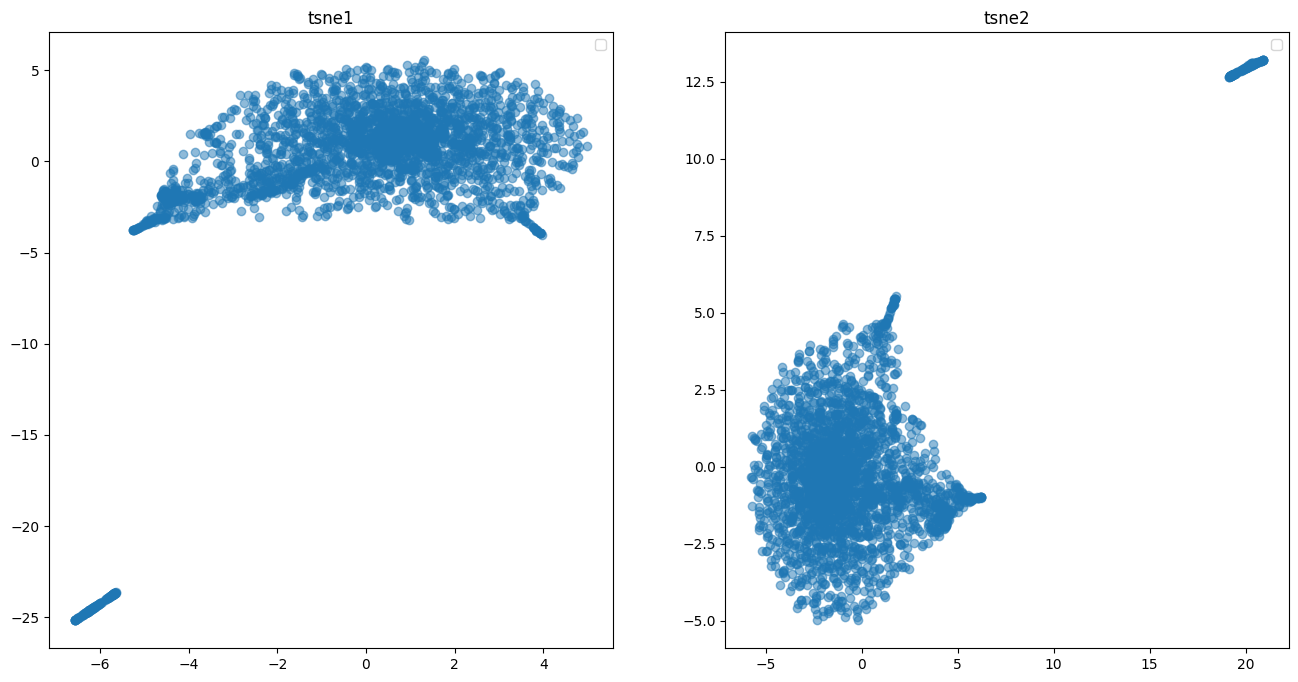

In [33]:
tsne_contrastive(df_global, df_global_jl)

In [36]:
df_target_test_sub = pd.read_csv("global-g2g_l2_test_sub.tsv", sep="\t")
print(df_target_test_sub.shape)
df_target_test_sub.head()

(10000, 4)


,l2,s_i,s_j,l2_log
0,901.0,HG02870,NA18947,6.804615
1,1307.0,HG02089,HG00334,7.176255
2,774.0,HG03871,NA18626,6.652863
3,1900.0,HG03729,HG02884,7.550135
4,2649503.0,NA18537,FI30911,14.789883


In [47]:
l2s_jl_test = []
ys = []
for i, row in df_target_test_sub.iterrows():
    s1, s2 = row['s_i'], row['s_j']
    _,d = dist_sq_l2((s1,s2), df_global_jl)
    d = np.log10(d+1)
    y = row['l2_log']
    l2s_jl_test.append(d)
    ys.append(y)

In [48]:
mse = np.mean((np.array(ys) - np.array(l2s_jl_test)) ** 2)
rmse = round(np.sqrt(mse), 2)

print(f"Mean Squared Error: {mse:.2f}")
print(f"log10(Mean Squared Error): {np.log10(mse):.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 24.55
log10(Mean Squared Error): 1.39
Root Mean Squared Error: 4.95


In [42]:
dist_sq_l2((s1,s2), df_global_jl)

(('HG02870', 'NA18947'), 896.4348514057659)

## Class balance

In [ ]:
df = pd.read_csv("global-g2g_l2.tsv", sep="\t")